## 0. 导入依赖 (Import Dependencies)

**[Ablation Study: Baseline (Only Species)]**
这是消融实验的基准线 (Baseline)。
在此配置中，我们将模型退化为标准的 GPT-2：
1. **关闭 Value Embeddings** (设 num_bins=0，或者通过不传 value_ids 实现)
2. **关闭 Condition Embeddings**
3. **关闭 Cross-Attention**
4. 仅使用 **Species Embeddings** (物种 ID)

In [1]:
import os
import torch
import warnings
from pickle import load
from argparse import Namespace
from configparser import ConfigParser
from importlib.resources import files

import pandas as pd
from torch.utils.data import Subset

from transformers import (
    Trainer,
    TrainingArguments,
)
from transformers.trainer_callback import EarlyStoppingCallback

from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForCausalLM
from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTDataCollator
from MiCoGPT.utils.tools import split_train_val_by_project_stratified

warnings.filterwarnings("ignore")

## 1. 基本参数设置 (Basic Parameters)

In [2]:
args = Namespace(
    input="../data/vCross/ResMicroDB_90338_vCross.pkl",
    # [Ablation] 输出路径: Baseline
    output="../models/pretrain_vCross_baseline",
    log="../logs/pretrain_vCross_baseline",
    prior_npz=None
)
VAL_RATIO = 0.10

## 2. 载入语料库 (Load Corpus)

In [3]:
print(f"Loading corpus from {args.input} ...")
all_corpus = load(open(args.input, "rb"))

if all_corpus.metadata is not None and "Split_Group" in all_corpus.metadata.columns:
    print("Subsetting corpus by Split_Group == 'A'...")
    corpus = all_corpus.subset_by_metadata(lambda df: df["Split_Group"] == "A")
else:
    print("Using full corpus (no Split_Group found or metadata missing).")
    corpus = all_corpus
    
tokenizer = all_corpus.tokenizer

Loading corpus from ../data/vCross/ResMicroDB_90338_vCross.pkl ...
Subsetting corpus by Split_Group == 'A'...
[subset_by_metadata] Selected 74557 samples out of 90338.


## 3. 构建 Baseline 模型 (Only Species)

为了禁用 Value Embedding，我们将 `num_bins` 设为 0 (或者在 collator 中不传 value_ids)。
由于我们的代码里 `value_ids` 默认会加上去，最简单的办法是保留 embedding 层但不给它传入有效数据，
或者更彻底一点：**在 Config 里设置 `num_bins=0` 并修改 collator 传全0**。

这里为了不动模型代码，我们**在 Config 中保留 num_bins=52**，但**修改 Collator 逻辑**，让其不返回 `value_ids` (或者全返回 0)。
不过，最干净的方法是利用 PyTorch 的特性：如果 `value_ids` 是 None，我们的模型代码会跳过加法。

In [4]:
cfg = ConfigParser()
cfg.read(files("MiCoGPT")/"resources/config.ini")

gpt2_config_dict = {
    "vocab_size":   tokenizer.vocab_size,
    "n_positions":  cfg.getint("GPT2", "n_positions"),
    "n_embd":       cfg.getint("GPT2", "n_embd"),
    "n_layer":      cfg.getint("GPT2", "n_layer"),
    "n_head":       cfg.getint("GPT2", "n_head"),
    "bos_token_id": tokenizer.bos_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "pad_token_id": tokenizer.pad_token_id,
}

config = MiCoGPTConfig(
    num_bins=52,          # 保持结构，但在输入端屏蔽
    condition_vocab_sizes=[], 
    prior_matrix_path=None,
    add_cross_attention=False,
    **gpt2_config_dict
)

model = MiCoGPTForCausalLM(config)
print("Baseline Model Built (Only Species)")

Baseline Model Built (Only Species)


## 4. 初始化数据整理器 (屏蔽 Value)

我们需要继承 `MiCoGPTDataCollator` 并覆盖 `__call__`，或者简单地在实例化后给它打个补丁。
这里我们定义一个 `BaselineDataCollator`，它继承原版，但在返回前把 `value_ids` 设为 None。

In [5]:
class BaselineDataCollator(MiCoGPTDataCollator):
    def __call__(self, examples):
        batch = super().__call__(examples)
        # [Baseline Key] 屏蔽 Value Embedding
        # 将 value_ids 设为 None，模型 forward 时就会跳过 value embedding 的加法
        batch["value_ids"] = None 
        return batch

collator = BaselineDataCollator(
    tokenizer=tokenizer,
    max_length=config.n_positions
)

## 5. 划分数据集

In [6]:
if isinstance(corpus, Subset):
    metadata = corpus.dataset.metadata
else:
    metadata = corpus.metadata

if metadata is not None and "Project_ID" in metadata.columns:
    print("Using stratified split by Project_ID...")
    train_dataset, val_dataset = split_train_val_by_project_stratified(
        corpus,
        val_ratio=VAL_RATIO,
        project_col="Project_ID"
    )
else:
    train_dataset, val_dataset = torch.utils.data.random_split(
        corpus, 
        [len(corpus)-int(len(corpus)*VAL_RATIO), int(len(corpus)*VAL_RATIO)], 
        generator=torch.Generator().manual_seed(42)
    )

Using stratified split by Project_ID...
[split] total_samples=74557, target_val~7456
[split] eligible_projects=304, eligible_samples=74367
[split] ineligible_projects=16, ineligible_samples=190
[split] actual_val=7456 (target~7456), train=67101


In [7]:
training_args = TrainingArguments(
    output_dir=f"{args.output}/checkpoints",
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    learning_rate=1e-3,
    weight_decay=0.01,
    logging_dir=args.log,
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    fp16=torch.cuda.is_available(),
    no_cuda=not torch.cuda.is_available(),
    report_to=["tensorboard"],
)

In [ ]:
# --- [New] 手动测试 Step 0 的 Validation Loss ---
print("Evaluating initial model (Step 0) ...")

# 调用 evaluate() 会使用 Trainer 初始化时传入的 eval_dataset 进行评估
init_eval_metrics = trainer.evaluate()

print("Initial Eval Metrics:", init_eval_metrics)

In [8]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
)
trainer.train()

Step,Training Loss,Validation Loss
500,5.113800,4.867764
1000,4.926400,4.737340
1500,4.876100,4.645500
2000,4.798100,4.570477
2500,4.745100,4.513813
3000,4.722200,4.470116
3500,4.646300,4.426200
4000,4.589100,4.389354
4500,4.586500,4.361192
5000,4.558800,4.334276


TrainOutput(global_step=42500, training_loss=4.234202618767234, metrics={'train_runtime': 4942.7635, 'train_samples_per_second': 678.78, 'train_steps_per_second': 21.213, 'total_flos': 3.521008999858176e+16, 'train_loss': 4.234202618767234, 'epoch': 20.27})

In [11]:
import json
import matplotlib.pyplot as plt

trainer.save_model(args.output)
tokenizer.save_pretrained(args.output)

log_history = trainer.state.log_history
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
if train_steps: plt.plot(train_steps, train_loss, label="Training Loss", alpha=0.7)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o", linestyle="--")
plt.title("Ablation: Baseline (Only Species)")
plt.legend()
plt.savefig(f"{args.output}/loss_curve.png")
plt.show()

NotImplementedError: 

✅ Hotfix applied: 'save_vocabulary' method has been injected into the tokenizer.
Model and Tokenizer saved to ../models/pretrain_vCross_baseline


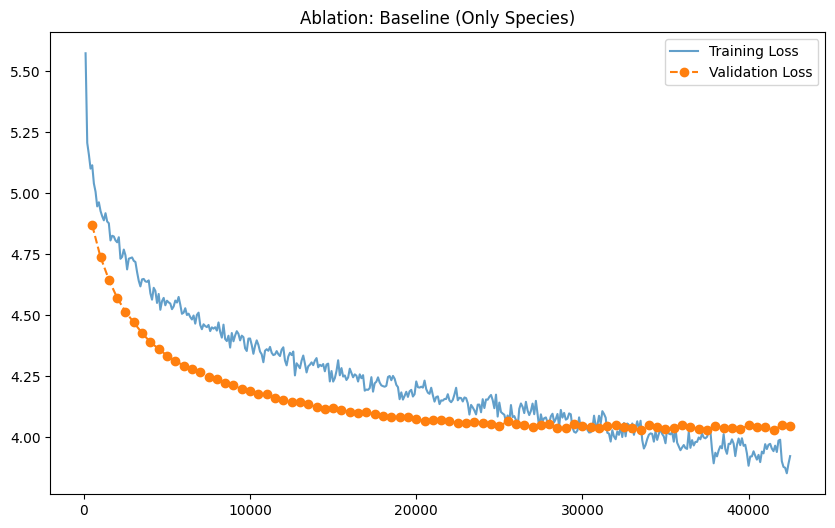

In [12]:
# 1. 保存模型
trainer.save_model(args.output)

# [Patch] Tokenizer 保存补丁
# 尝试使用标准 save_pretrained，如果报错(NotImplementedError)，则使用 joblib 备份
try:
    corpus.tokenizer.save_pretrained(args.output)
    print(f"Tokenizer saved to {args.output} via save_pretrained")
except NotImplementedError:
    import joblib
    print("Warning: Tokenizer.save_pretrained not implemented. Saving tokenizer object via joblib instead.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")
except Exception as e:
    # 兜底：任何其他错误也尝试用 joblib 救一下
    import joblib
    print(f"Warning: Failed to save tokenizer via save_pretrained ({e}). Saving via joblib.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")

# 保存 Label Encoder (关键)
import joblib
joblib.dump(le, f"{args.output}/label_encoder.joblib")
print(f"Model and LabelEncoder saved to {args.output}")

# 2. 导出日志
log_history = trainer.state.log_history
import json
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 3. 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]

plt.figure(figsize=(12, 5))

# Loss 曲线
plt.subplot(1, 2, 1)
if train_steps: plt.plot(train_steps, train_loss, label="Train Loss", alpha=0.6)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Val Loss", marker="o")
plt.title("Loss Curve")
plt.legend()

# F1 曲线
plt.subplot(1, 2, 2)
if eval_steps and eval_f1: 
    plt.plot(eval_steps, eval_f1, label="Val F1", color="orange", marker="s")
plt.title("F1 Score Curve")
plt.legend()

plt.savefig(f"{args.output}/training_curve.png")
plt.show()